In [1]:
import os
import astropy.io.ascii
from scipy.optimize import leastsq

# personal import
from sjoert import sync
import sjoert

import emcee
import corner

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cycler import cycler

import pickle
import json

In [2]:
import logging
logging.getLogger().setLevel("INFO")

100%|██████████| 20/20 [00:02<00:00,  7.06it/s]
INFO:root:done building interpolator. testing:


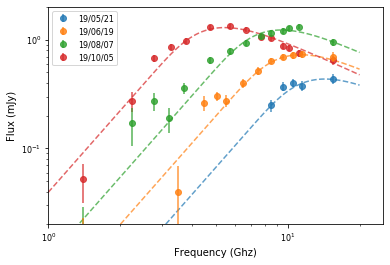

INFO:root:28, v/c from R_eq    (spherical emitting region): 0.10862271817507628
INFO:root:78, v/c from R_eq    (spherical emitting region): 0.08923359901631932
INFO:root:136, v/c from R_eq    (spherical emitting region): 0.1647628103378635
INFO:root:v/c for neutrino  (spherical emitting region): {(R_single[3,0]-1e15) / ((5)*3600*24) / 3e10}


writing:
 /Users/robertstein/Code/bran_stark_paper_code/at2019dsg/data/at2019dsg_RB_fit_p3.0.dat


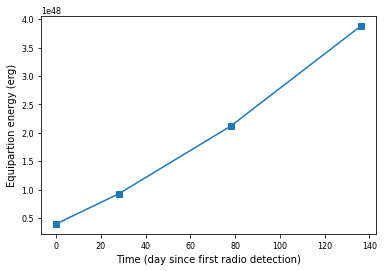

In [3]:
# local import
from importlib import reload
from at2019dsg.plotting import big_fontsize, fontsize, fig_width, fig_height, plot_dir, golden_ratio, marker_size, dpi
from at2019dsg.data import  bran_disc, t_peak_mjd, radio_rec, data_dir
from at2019dsg.core import equipartition_functions
from at2019dsg.core.equipartition_functions import *
from at2019dsg.core.fit_radio_data import R_single, B_single

In [4]:
credit_int = 68.2689492137086

nwalkers = 50
nsteps = 1500
burnin = 1000

silent = False
wait = False
plotname = os.path.join(plot_dir, 'bran')

z = equipartition_functions.z
D_L = sjoert.stellar.lumdis(z, h=0.7)

data_rec = radio_rec

# ---
#  input by hand the dates we want to fit the radius and B-field. 
mjd_fit = np.array([58625, 58653, 58703, 58761]) #58819 last epoch has only MeerKAT and AMI data
#mjd_fit = np.array([58761])# last epoch only (gives p=3)


# remove data that's not close enough to MJDs we want to fit for
dfit = np.array([min(abs(d['mjd']-mjd_fit)) for d in data_rec])
data_rec = data_rec[dfit<14]
data_rec = data_rec[data_rec['inst']!='eMERLIN']
#data_rec['eflux_mJy'][data_rec['inst']=='AMI'] *= 10 #data_rec

try:
    dummy = R_single[:,0]
except NameError:
    logging.error('First time you need to run fit_radio_data to get least least-square results')
# ---
# free paremeters with our best guess (from least-square fit)
R_arr = R_single[:,0]
B_arr = B_single[:,0]
R_arr = np.log10(R_arr)
B_arr = np.log10(B_arr)
p_electron = 3.0										# electorn power-law index
Fbase0 = 0.0 											# baseline flux in mJy @1.4 GHz
Fbase1 = -1 											# spectral index of baseline flux
lnf = -2 												# fudge factor for errors

# fix parameter:
phi0 = np.pi/4.
phi0 = 30/180*np.pi



prior_dict={}
#prior_dict["p_electron"] =  {"min":2.2,"max":4.00,"sigma":None,"value":p_electron}
prior_dict["p_electron"] =  {"min":2.1,"max":4.00,"sigma":0.15,"value":p_electron}
prior_dict["Fbase0"] =  {"min":0,"max":0.10,"sigma":None,"value":Fbase0}
prior_dict["Fbase1"] =  {"min":-2,"max":0,"sigma":None,"value":Fbase1}
prior_dict["lnf"] =    {"min":-5,"max":-2,"sigma":None,"value":-3}

# make sure the B-field doesn't run out of bounds of the interpolator
for i in range(len(R_arr)):
    prior_dict["B"+str(int(mjd_fit[i]-mjd_fit[0]))] =  {"min":np.log10(min(BB)),"max":np.log10(max(BB)),"sigma":None,"value":B_arr[i]}
    prior_dict["R"+str(int(mjd_fit[i]-mjd_fit[0]))] =  {"min":15.5,"max":17.5,"sigma":None,"value":R_arr[i]}


# define the ordering of the parameters 
par_names  = ["R"+str(int(mjd_fit[i]-mjd_fit[0])) for i in range(len(R_arr))]
par_names += ["B"+str(int(mjd_fit[i]-mjd_fit[0])) for i in range(len(R_arr))]
par_names += ["p_electron","Fbase0", "Fbase1", "lnf"]

In [5]:
def model_func(p, mjd, nu, verbose=False):
    
    R = 10**np.interp(mjd, mjd_fit, p[0:len(mjd_fit)])
    B = np.interp(mjd, mjd_fit, p[len(mjd_fit):len(mjd_fit)*2])	
    p_electron = np.repeat( np.log10(p[len(mjd_fit)*2]), len(mjd))
    Fbase0 = p[len(mjd_fit)*2+1]
    Fbase1 = p[len(mjd_fit)*2+2]

    # do synchtron prediction
    #mout = np.zeros(len(mjd))
    #for i in range(len(mjd)):
    mout = model_single_tab(nu, B, R, p_electron)	
    
    # convert to mJy
    mout *= 1e23*1e3 
    if verbose:
        logging.debug(f'log10(B) {B}')
        logging.debug(f'log10(R) {np.log10(R)}')
        logging.debug(f'p_electr {p[len(mjd_fit)*2]}')
        logging.debug(f'model single outout in mJy:{mout}')

    # add baseline flux
    mout += Fbase0*(10**nu/1.28e9)**(Fbase1)


    return mout

# fit normalization for parameters with Gaussian prior (likely none in this project)
for par in par_names:
    if prior_dict[par].get("sigma") is not None:
        # if not silent:
        #     print('{2:7} prior {0:0.2f} +/- {1:0.3f}'.format(prior_dict[par]["value"], prior_dict[par]["sigma"], par))        
        prior_dict[par]["norm"] = -np.log(prior_dict[par]["sigma"])
        prior_dict[par]["ivar"] = 1/prior_dict[par]["sigma"]**2

# Set up the sampler.
ndim= len(par_names)
#guess_pos = result["x"]
#guess_pos = [norm_ls, np.log10(50), 0+tp_prior_max/2.,  -5/3., np.log(0.1)]
guess_pos = [prior_dict[par]["value"] for par in par_names]

par_with_gauss_prior = [par for par in par_names if prior_dict[par]['sigma']]
logging.info(f'parameters with gaussian prior: {par_with_gauss_prior}')

#check limits
for i, par in enumerate(par_names):
    if (guess_pos[i]<prior_dict[par]["min"]) or (guess_pos[i]>prior_dict[par]["max"]):
        logging.warning('WARNING!! the start position ({0:0.3f}) is outside the limits of this prior: {1}'.format(guess_pos[i], prior_dict[par]))




# Define the prior function     
def lnprior(theta):
    
    #check limits
    for i, par in enumerate(par_names):
        if theta[i]<prior_dict[par]["min"]:
            return -np.inf
        if theta[i]>prior_dict[par]["max"]:
            return -np.inf    

    # apply Gausian priors (if any)
    out = 0
    for i, par in enumerate(par_names):
        if par in par_with_gauss_prior:
            out += -0.5*(theta[i]-prior_dict[par]["value"])**2 * prior_dict[par]["ivar"] + prior_dict[par]["norm"]
    return out


# Define the likelihood, assuming Gaussian errors with fudge factor in the variance
def lnlike(theta, mjd, y, yerr, nu):
    
    # get a power-law
    model_y = model_func(theta[0:-1], mjd, nu)

    lnf = theta[-1]
    # print ('pars:',theta)
    # print ('model:', model_y)
    # key = input()
    inv_sigma2 = 1.0/(yerr**2 + model_y**2*np.exp(2*lnf))
    out = -0.5*(np.sum((y-model_y)**2*inv_sigma2 - np.log(inv_sigma2)))
    return out

# Define the probability function as likelihood * prior.
def lnprob(theta, x, y, yerr, nu):
    
    lp = lnprior(theta)
    
    # print ('pars:',theta)
    # print ('prior:', lp)
    
    # for i, par in enumerate(par_names):
    #     print (par,theta[i], prior_dict[par]["min"], prior_dict[par]["max"])
    #     print (theta[i]<prior_dict[par]["min"])
    #     print (theta[i]>prior_dict[par]["max"])

    # key = input()

    if not np.isfinite(lp):
        return -np.inf
    out = lp + lnlike(theta, x, y, yerr, nu)
    return out


guess_pos = [prior_dict[par]["value"] for par in par_names]

INFO:root:parameters with gaussian prior: ['p_electron']


In [6]:
logging.info("MCMC start:")

for l in range(ndim):
    logging.info("{0:7}  = {1:0.2f}".format(par_names[l], guess_pos[l]))

# add small amount of scatter to start of walkers
pos = [guess_pos + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

# let's go
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
        args=(data_rec['mjd'], data_rec['flux_mJy'], data_rec['eflux_mJy'], np.log10(data_rec['nu_GHz']*1e9*(1+z))))

# Clear and run the production chain.    
sampler.run_mcmc(pos, nsteps, rstate0=np.random.get_state(), progress=True)

par_names_walk = par_names

INFO:root:MCMC start:
INFO:root:R0       = 16.11
INFO:root:R28      = 16.32
INFO:root:R78      = 16.51
INFO:root:R136     = 16.76
INFO:root:B0       = 0.02
INFO:root:B28      = -0.11
INFO:root:B78      = -0.22
INFO:root:B136     = -0.45
INFO:root:p_electron  = 3.00
INFO:root:Fbase0   = 0.00
INFO:root:Fbase1   = -1.00
INFO:root:lnf      = -3.00
  0%|          | 0/1500 [00:00<?, ?it/s]/usr/local/anaconda3/envs/bran_stark_paper/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1500/1500 [01:17<00:00, 19.30it/s]


In [7]:
if plotname:        

    fig, axes = plt.subplots(len(par_names_walk), 1, sharex=True, figsize=(10.4, 11.7))

    for l, par in enumerate(par_names_walk):
        axes[l].plot(sampler.chain[:, :, l].T, color="k", alpha=0.4)
        axes[l].yaxis.set_major_locator(MaxNLocator(5))
        axes[l].set_ylabel(par)

    axes[l].set_xlabel("step number")

    fig.tight_layout(h_pad=0.0)
    fig.savefig(plotname+"-mcmc-walkers.png")
    if wait:
        key = input()
    plt.close()

# Make the triangle plot.
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

# dump the samples
pickle.dump(samples, open(os.path.join(data_dir, 'mcmc_samples.pkl'),'wb'))

if plotname:        

    fig = corner.corner(samples, labels=par_names)
    fig.savefig(plotname+"-mcmc-triangle.pdf")
    if wait:
        key = input()
    plt.close()


# Compute the quantiles.
out_tup = [np.array([v[1], v[1]-v[0], v[2]-v[1]]) for v in zip(*np.percentile(samples, [50-credit_int/2., 50, 50+credit_int/2.], axis=0))] #[16, 50, 84]
    
out_dict = {par:tuple(out_tup[l]) for l, par in enumerate(par_names)}
bf_arr = np.array([out_tup[l][0] for l, par in enumerate(par_names[0:-1])])

logging.info("MCMC result:")
for par in par_names:
    logging.info("{0:10} = {1[0]:0.3f} -{1[1]:0.3f} +{1[2]:0.3f}".format(par, out_dict[par]))

# dump mcmc percentiles result
json.dump(out_dict, open(os.path.join(data_dir, 'at2019dsg_mcmc.json'), 'w'), indent=3)

INFO:root:MCMC result:
INFO:root:R0         = 16.085 -0.027 +0.025
INFO:root:R28        = 16.286 -0.019 +0.019
INFO:root:R78        = 16.497 -0.016 +0.018
INFO:root:R136       = 16.746 -0.016 +0.015
INFO:root:B0         = 0.005 -0.033 +0.034
INFO:root:B28        = -0.107 -0.026 +0.026
INFO:root:B78        = -0.237 -0.025 +0.026
INFO:root:B136       = -0.477 -0.024 +0.025
INFO:root:p_electron = 2.896 -0.101 +0.110
INFO:root:Fbase0     = 0.088 -0.009 +0.007
INFO:root:Fbase1     = -0.117 -0.199 +0.090
INFO:root:lnf        = -3.504 -0.856 +0.598


INFO:root:next: make tables
/usr/local/anaconda3/envs/bran_stark_paper/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/envs/bran_stark_paper/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/anaconda3/envs/bran_stark_paper/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/envs/bran_stark_paper/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/anaconda3/envs/bran_stark_paper/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

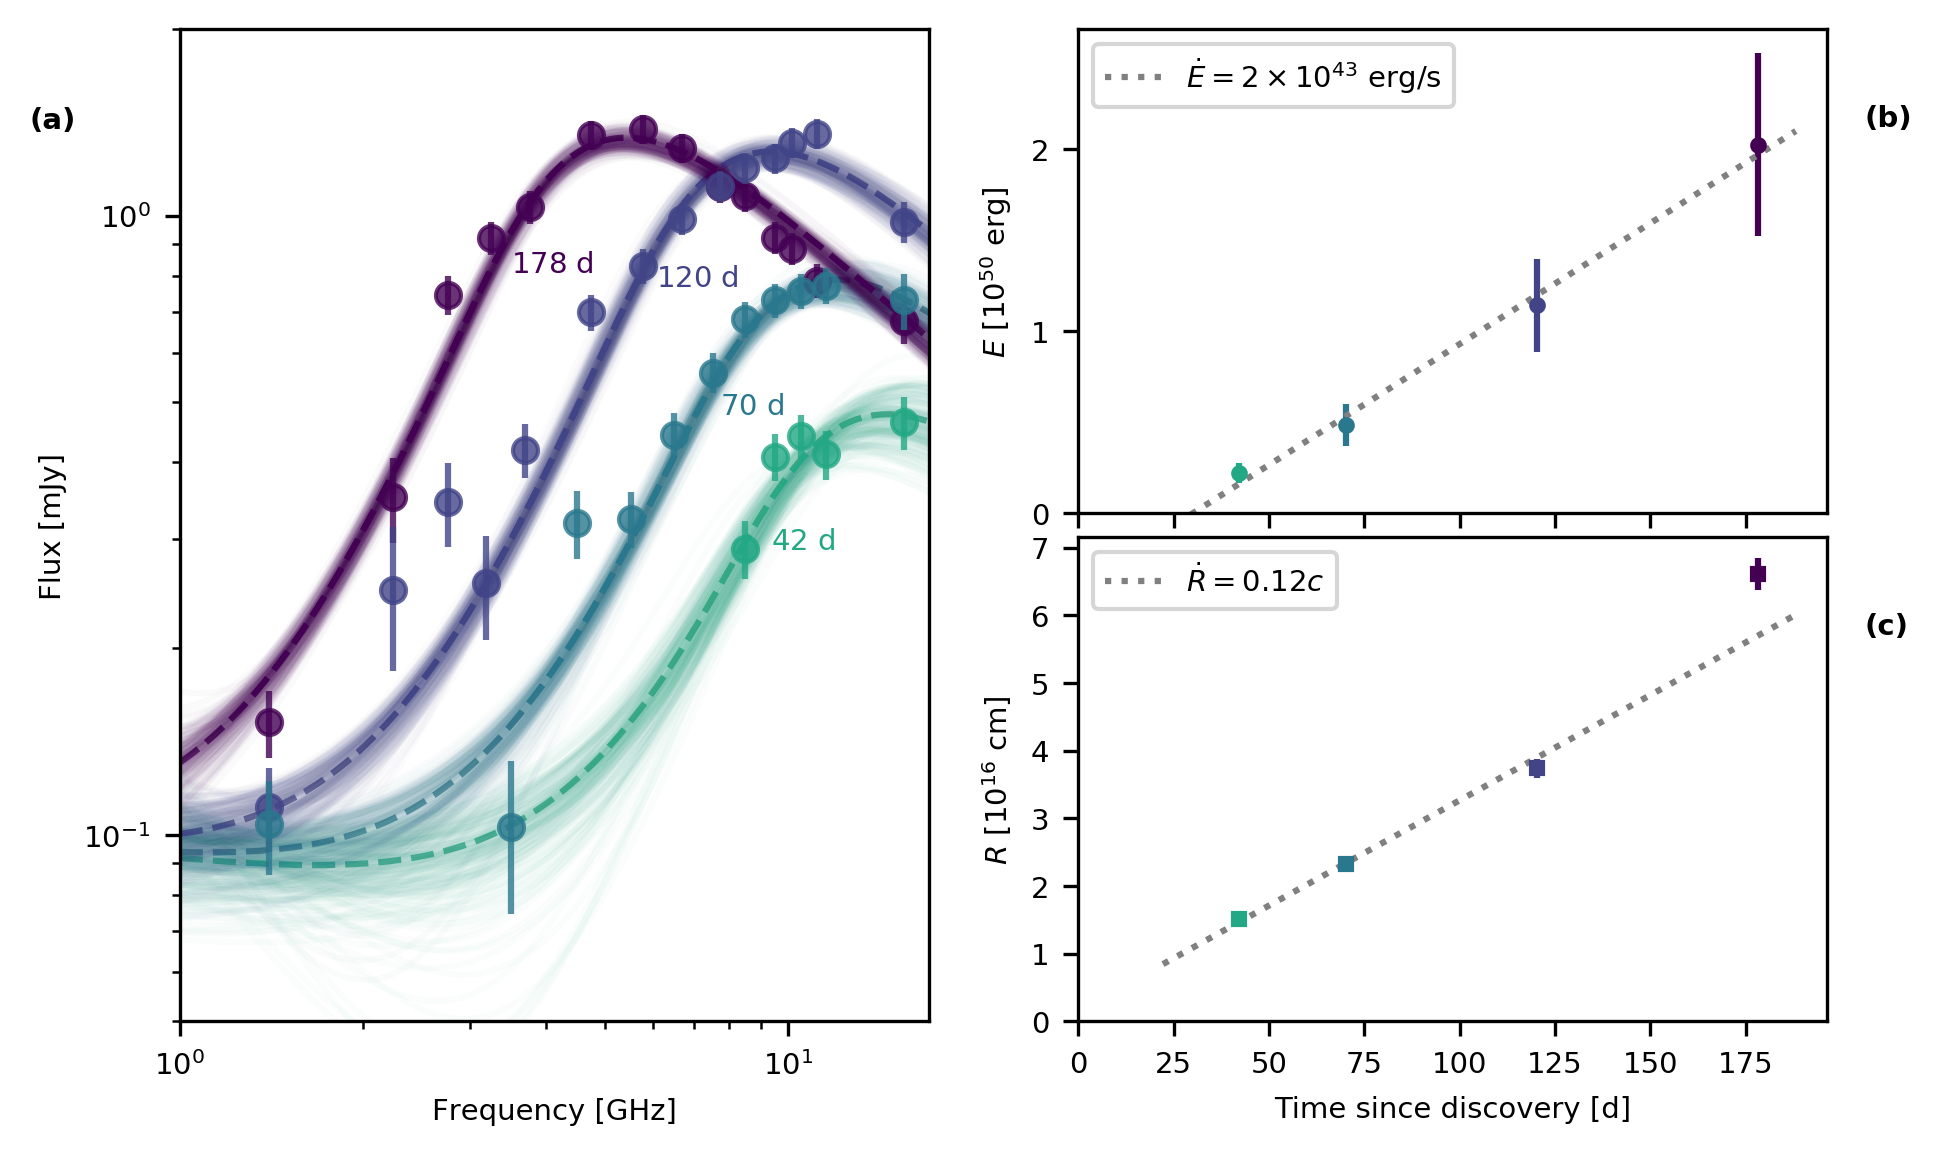

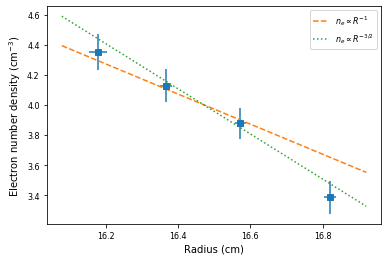

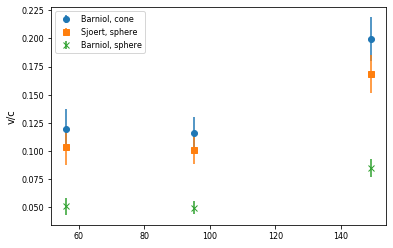

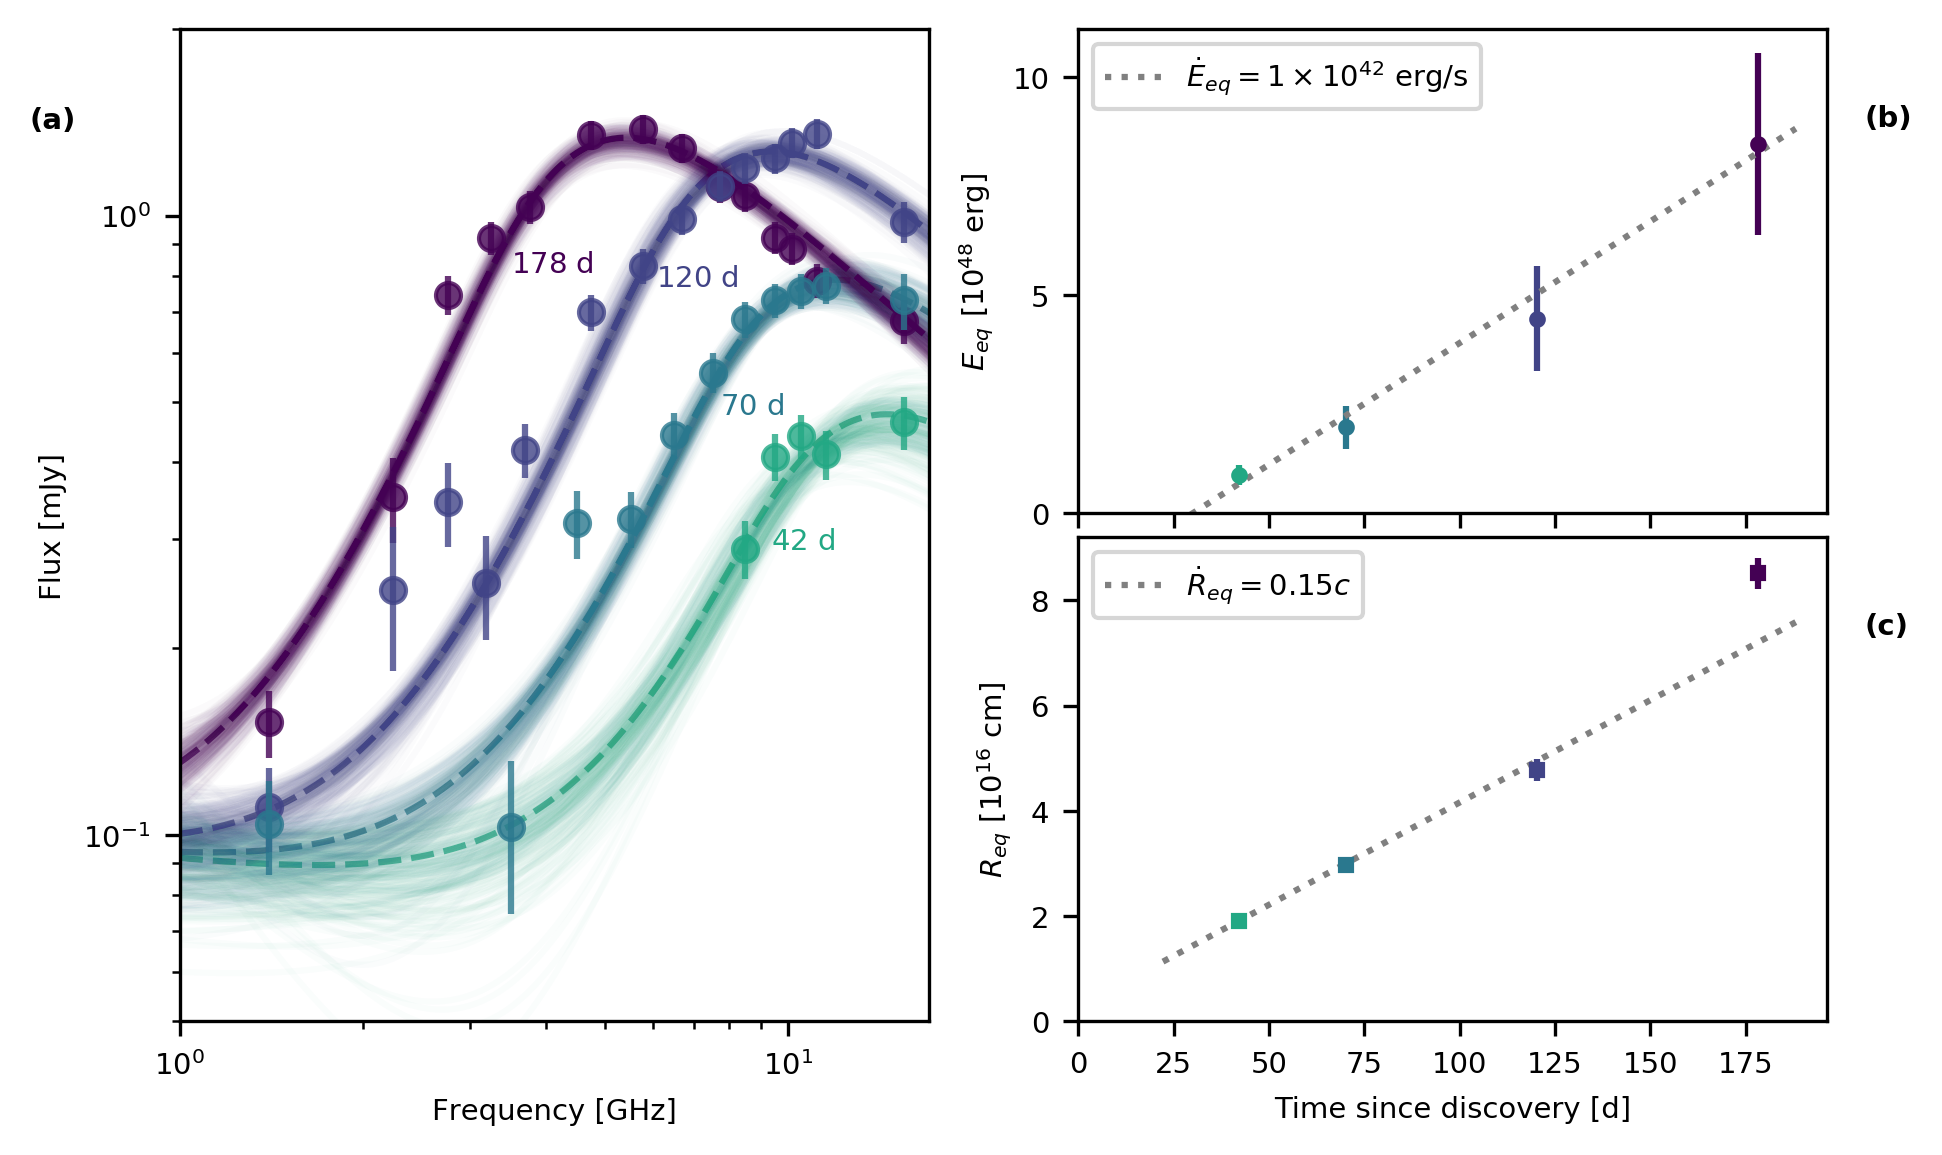

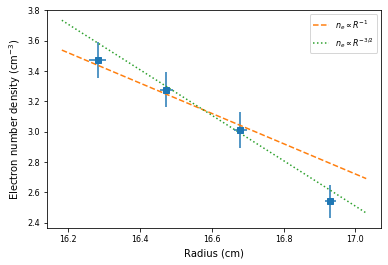

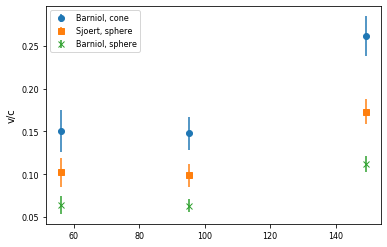

In [8]:
logging.info('next: make tables')

# ---
# loop over a few micro physical-paramter-model options and compute Eq parameters

micro_models = [] 
#micro_models.append({'epsilon_e':1/(1+6/11),'epsilon_B':1/(1+11/6), 'name':'Eqp'}) # None is needed because in true Equipartition epsilon_e is not defined (bc there are no protons) 
micro_models.append({'epsilon_e':None,'epsilon_B':None, 'name':'Eqp'}) # None is needed because in true Equipartition epsilon_e is not defined (bc there are no protons) 
micro_models.append({'epsilon_e':0.1, 'epsilon_B':1e-3, 'name':'nonEqp'})

for model in micro_models[::-1]: 
    
    # --- 
    # loop over sample at each MJD and 
    # make nice SED plot
    fig = plt.figure(figsize=(fig_width, fig_width/golden_ratio), dpi=dpi)

    ax1 = plt.subplot(121)
    axE = fig.add_subplot(2,2,2)    
    axR = fig.add_subplot(2,2,4, sharex=axE)
    
    ax1.annotate("(a)", (-0.2, 0.9), xycoords="axes fraction", fontsize=big_fontsize, fontweight='bold')
    axE.annotate("(b)", (1.05, 0.8), xycoords="axes fraction", fontsize=big_fontsize, fontweight='bold')
    axR.annotate("(c)", (1.05, 0.8), xycoords="axes fraction", fontsize=big_fontsize, fontweight='bold')
    cmap = mpl.cm.get_cmap('viridis')
    custom_cycler = (cycler(color=([cmap(i) for i in np.linspace(0.6,0.0,len(mjd_fit))])))
    fig.gca().set_prop_cycle(custom_cycler)
    
    for ax in [ax1, axE, axR]:
        ax.set_prop_cycle(custom_cycler)
        ax.tick_params(axis='both', which='major', labelsize=big_fontsize)

    Nlc = 200
    mjd0 = bran_disc.mjd
    #mjd0 = 58584 # original estimate of first detection
    xx = np.logspace(9,10.3, 1000)

    for i, mjd in enumerate(mjd_fit): 

        it = abs(data_rec['mjd']-mjd)<10
        ii = it * (data_rec['eflux_mJy']>0)

        if sum(ii)>1:
            nu = data_rec[ii]['nu_GHz']
            Fnu = data_rec[ii]['flux_mJy'] 
            Fnu_err = data_rec[ii]['eflux_mJy'] 
            base = out_dict['Fbase0'][0]*(nu/1.4)**(out_dict['Fbase1'][0]) # subtract baseline

            lbl = sjoert.simtime.mjdtodate(np.mean(data_rec['mjd'][it])).strftime('%y/%m/%d')
            line = ax1.errorbar(nu, Fnu,Fnu_err, fmt='o', label=lbl, zorder=10-i, alpha=0.8)

            base_xx = out_dict['Fbase0'][0]*(xx/1.4e9)**(out_dict['Fbase1'][0]) # subtract baseline

            bf_func = model_func(bf_arr, np.repeat(mjd, len(xx)), np.log10(xx),verbose=False) #-base_xx
            ax1.plot(xx/1e9, bf_func,  '--',alpha=0.7, color=line[0].get_color()) #label=ll1
            xmax = xx[np.argmax(bf_func)]
            ax1.annotate('${0:0.0f}$ d'.format(mjd-mjd0), (xmax/1e9/1.55, max(bf_func)/1.65), color=line[0].get_color(), size=big_fontsize)
#             ax1.annotate('${0:0.0f}$ d'.format(mjd-mjd0), (xmax/1e9/0.9, max(bf_func)/0.95), color=line[0].get_color(), size=fontsize)


            # loop over samples from posterior
            for l, parms in enumerate((samples[np.random.randint(len(samples), size=Nlc)])):

                # check for rougue walkers
                df = np.interp(np.log10(5e9), np.log10(xx), bf_func) / model_func(parms[0:-1], np.array([mjd]), np.array([np.log10(5e9)]))

                if abs(np.log10(df))<0.3:

                    this_base = parms[len(mjd_fit)*2+1]* (xx/1.4e9)**parms[len(mjd_fit)*2+2]
                    this_model = model_func(parms[0:-1], np.repeat(mjd, len(xx)), np.log10(xx))
                    ax1.plot(xx/1e9, this_model,  '-',alpha=0.02, color=line[0].get_color()) #label=ll1
                else:
                    logging.warning(f'rejecting walker ({l})')

    ax1.set_xlim(1.0,17) 
    ax1.set_ylim(0.05, 2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('Frequency [GHz]', fontsize=big_fontsize)
    ax1.set_ylabel('Flux [mJy]', fontsize=big_fontsize)

    
    # to do, move this scaling into the sjoert.sync
    epsilon_B, epsilon_e = model['epsilon_B'], model['epsilon_e']
    if epsilon_e is not None:
        #eta = (epsilon_B/1-epsilon_e) / (6/11) 				# Barniol, super naive (likely wrong)
        eta = (epsilon_B/epsilon_e) / (6/11 *(1+1/epsilon_e)) 	# Barniol, more likely
        eta = (epsilon_B/ (1-epsilon_B)) / (6/11) 				# my derivation
    else:
        eta =1

    Eeq_corr = (11/17)*eta**(-6/17) + (6/17) *eta**(11/17)
    Req_corr = eta**(1/17)

    samples_dict = {k:np.zeros((len(mjd_fit), Nlc)) for k in \
        ('F_p', 'nu_p', 'R_SJ', 'R_cone', 'R_sphere', 'E_SJ','E_cone','E_sphere', 'B_SJ','B_sphere','B_cone',  'n_electr_cone','n_electr_sphere', 'v_SJ', 'v_cone', 'v_sphere')}


    # find Fpeak and nu_peak posterios sample in each epoch (sorte in table for later use)
    for i, mjd in enumerate(mjd_fit): 
        
            xx = np.logspace(9,10.3, 1000)
            bf_func = model_func(bf_arr, np.repeat(mjd, len(xx)), np.log10(xx),verbose=False) 
            for l, parms in enumerate((samples[np.random.randint(len(samples), size=Nlc)])):

                # check for rougue walkers
                df = np.interp(np.log10(5e9), np.log10(xx), bf_func) / model_func(parms[0:-1], np.array([mjd]), np.array([np.log10(5e9)]))

                if abs(np.log10(df))<0.3:
                    
                    this_base = parms[len(mjd_fit)*2+1]* (xx/1.4e9)**parms[len(mjd_fit)*2+2]
                    this_model = model_func(parms[0:-1], np.repeat(mjd, len(xx)), np.log10(xx))

                    imax = np.argmax(this_model-this_base)
                    samples_dict['F_p'][i,l] = this_model[imax]-this_base[imax] #mJy, baseline subtracted
                    samples_dict['nu_p'][i,l] = xx[imax]

                    this_B = 10**parms[len(mjd_fit)+i]
                    this_R = 10**parms[i]
                    this_p = parms[len(mjd_fit)*2]
                    #this_p = np.random.normal(3, 0.15) # fixed a last epoch measurement
                    
                    samples_dict['R_SJ'][i,l] = this_R
                    samples_dict['B_SJ'][i,l] = this_B

                    # two cones
                    D_cone = this_R/np.tan(phi0)
                    #fA = (1-cos(phi0))/(1-cos(1))
                    fA = 2 * 2*pi*(1-cos(phi0))/(4*pi)  # seems that 4*pi is need for the Newtonian case of Barniol equations
                    if phi0<pi/4:
                        fV = 2 * 1/3.*pi* D_cone*(this_R)**2 / (pi*this_R**3) # appropiate for small phi (<45 deg?)
                    else:
                        fV = 4/3*fA
                    
                    #fV *= 1-0.9**3 # emitting region is with in 0.1 of total length

                    who = 'Barniol'				
                    samples_dict['R_cone'][i,l] = Req_corr * sync.Req(this_model[imax], D_L, xx[imax], z, fA=fA, fV=fV, epsilon_e=epsilon_e, p=this_p, who=who)
                    samples_dict['E_cone'][i,l] = Eeq_corr * sync.Eeq(this_model[imax], D_L, xx[imax], z, fA=fA, fV=fV, epsilon_e=epsilon_e, p=this_p, who=who)
                    cone_volume = (fV*pi*(samples_dict['R_cone'][i,l])**3)
                    

                    if epsilon_e is not None:
                        samples_dict['n_electr_cone'][i,l] = samples_dict['E_cone'][i,l]/(sync.me*sync.c**2) * (1-epsilon_B)/ (1+1/epsilon_e) * (-this_p+2) / (-this_p-1) / gamma_min / cone_volume 
                        samples_dict['B_cone'][i,l] = sqrt(samples_dict['E_cone'][i,l]*epsilon_B*8*pi / cone_volume) 
                    else:
                        samples_dict['n_electr_cone'][i,l] = samples_dict['E_cone'][i,l]/(sync.me*sync.c**2) /(1+6/11) * (-this_p+2) / (-this_p-1) / gamma_min / cone_volume 
                        samples_dict['B_cone'][i,l] = sqrt(samples_dict['E_cone'][i,l]/(1+11/6)*8*pi / cone_volume) # note this only works without hot protons

                    # sphere
                    samples_dict['E_SJ'][i,l] =  4/3*pi*(this_R)**3 * (this_B)**2/(8*np.pi) 

                    fA = 1 # in Newtonian case!
                    fV = 4/3.
                    samples_dict['R_sphere'][i,l] = Req_corr * sync.Req(this_model[imax], D_L, xx[imax], z, fA=fA, fV=fV, epsilon_e=epsilon_e, p=this_p, who=who)
                    samples_dict['E_sphere'][i,l] = Eeq_corr * sync.Eeq(this_model[imax], D_L, xx[imax], z, fA=fA, fV=fV, epsilon_e=epsilon_e, p=this_p, who=who)
                    sphere_volume = (fV*pi*(samples_dict['R_sphere'][i,l])**3)

                    if epsilon_e is not None:
                        samples_dict['n_electr_sphere'][i,l] = samples_dict['E_sphere'][i,l]/(sync.me*sync.c**2) * (1-epsilon_B)/ (1+1/epsilon_e) * (-this_p+2) / (-this_p-1) / gamma_min / sphere_volume 
                        samples_dict['B_sphere'][i,l] = sqrt(samples_dict['E_sphere'][i,l]*epsilon_B*8*pi / sphere_volume) # note this only works without hot protons
                    else:
                        samples_dict['B_sphere'][i,l] = sqrt(samples_dict['E_sphere'][i,l]*1/(1+11/6)*8*pi / sphere_volume) # note this only works without hot protons
                        samples_dict['n_electr_sphere'][i,l] = samples_dict['E_sphere'][i,l]/(sync.me*sync.c**2) /(1+6/11) * (-this_p+2) / (-this_p-1) / gamma_min / sphere_volume 
                    
                    
                                
                else:
                    print ('rejecting sample')

    # get the velocities, use rest-frame time
    for i, mjd in enumerate(mjd_fit[0:-1]): 
        for k in ('SJ', 'cone', 'sphere'):
            samples_dict['v_'+k][i, :] = (samples_dict['R_'+k][i, :]-samples_dict['R_'+k][i+1, :]) / ((mjd_fit[i]-mjd_fit[i+1])*3600*24/(1+z)) /3e10 


    # write the best-fit and uncertainty as a function of time
    bf_all_cols = ['time']+list(samples_dict.keys()) + ['e'+x for x in samples_dict.keys()]
    bf_dict = {k:0. for k in  bf_all_cols}
    bf_rec = sjoert.rec.dict2rec(bf_dict, n=len(mjd_fit))

    for i, mjd in enumerate(mjd_fit): 
        #dk = str(int(mjd_fit[i]-mjd_fit[0]))
        for k in samples_dict.keys():
            iok = samples_dict[k][i, :]!=0
            med, sig = np.log10(np.median(samples_dict[k][i, iok])), np.std(np.log10(samples_dict[k][i,iok]))
            # do linear for v
            if k[0] =='v':
                med, sig = np.median(samples_dict[k][i, iok]), np.std(samples_dict[k][i,iok])
            bf_rec[k][i], bf_rec['e'+k][i] = med, sig

    for k in ('SJ', 'cone', 'sphere'):	
        bf_rec['v_'+k][-1] = 0
        bf_rec['ev_'+k][-1] = 0

    bf_rec['time'] = mjd_fit - mjd0

    out_cols = \
    ['time',
     'F_p',
     'eF_p',
     'nu_p',
     'enu_p',
     'R_SJ', 
     'R_sphere',
     'R_cone',
     'eR_SJ',
     'eR_sphere',
     'eR_cone',
     'E_SJ',
     'E_sphere',
     'E_cone',
     'eE_SJ',
     'eE_sphere',
     'eE_cone',
     'B_SJ',
     'B_sphere',
     'B_cone',
     'eB_SJ', 
     'eB_sphere',
     'eB_cone',
     'n_electr_cone',
     'n_electr_sphere',
     'en_electr_cone',
     'en_electr_sphere',
     'v_SJ', 
     'v_sphere', 
     'v_cone',
     'ev_SJ',
     'ev_sphere',
     'ev_cone']

    fname = os.path.join(data_dir, 'at2019dsg_mcmc_time_{0}.dat'.format(model['name']))

    astropy.io.ascii.write([bf_rec[x] for x in out_cols], fname, 
            format='fixed_width', 
            names = out_cols,
            formats={k:'0.3f' for k in out_cols},
            overwrite=True)

    xx = np.linspace(min(bf_rec['time'])-20, max(bf_rec['time'])+10)
    #xx = np.linspace(10, max(bf_rec['time'])+2)

    if epsilon_e is None:
        lbl_eqp = '_{eq}'
        E_norm = 1e48
        dE_norm = 1e42
        v_plt = 0.15
        x0_plt = 7
    else:
        lbl_eqp = ''
        E_norm = 1e50
        dE_norm = 1e43
        v_plt = 0.12
        x0_plt = 5

    for i in range(len(mjd_fit)):
        axE.errorbar(bf_rec[i]['time'], 10**bf_rec[i]['E_cone']/E_norm, np.log(10)*10**bf_rec[i]['E_cone']*bf_rec[i]['eE_cone']/E_norm, fmt='o', ms=marker_size)
        axR.errorbar(bf_rec[i]['time'], 10**bf_rec[i]['R_cone']/1e16, np.log(10)*10**bf_rec[i]['R_cone']*bf_rec[i]['eR_cone']/1e16, fmt='s',ms=marker_size)
        #axE.errorbar(bf_rec[i]['time'], bf_rec[i]['E_cone'],bf_rec[i]['eE_cone'], fmt='o', ms=5)
        #axR.errorbar(bf_rec[i]['time'], bf_rec[i]['R_cone'], bf_rec[i]['eR_cone'], fmt='s',ms=5)


    dEeqdt = (max(10**bf_rec['E_cone'])-min(10**bf_rec['E_cone']))/((mjd_fit[-1]-mjd_fit[0])/(1+z)*3600*24)
    axE.plot(xx,  dEeqdt*3600*24*(xx-30)/E_norm/(1+z), ':',color='grey', alpha=1, 
                label=r'$\dot{{E}}{1} = {0:0.0f} \times 10^{{{2:0.0f}}}$ erg/s'.format(dEeqdt/dE_norm, lbl_eqp, np.log10(dE_norm)))

    axR.plot(xx, (xx+x0_plt)*24*3600*v_plt*3e10/1e16, ':',color='grey', alpha=1, 
            label='$\dot{{R}}{0}={1} c$'.format(lbl_eqp, v_plt))

    axE.set_ylabel('$E{0}~[10^{{{1:0.0f}}}$ erg]'.format(lbl_eqp, np.log10(E_norm)), fontsize=big_fontsize)
    axR.set_ylabel('$R{0}~[10^{{16}}$ cm]'.format(lbl_eqp), fontsize=big_fontsize)

    axR.set_xlabel('Time since discovery [d]', fontsize=big_fontsize)
    #axE.set_yscale('log')
    axE.set_ylim(0, max(axE.get_ylim()))
    axR.set_ylim(0, max(axR.get_ylim()))
    axR.set_xlim(0, max(axR.get_xlim()))
    plt.setp(axE.get_xticklabels(), visible=False)
    #plt.tight_layout()
    axE.legend(loc=2, fontsize=big_fontsize)
    axR.legend(loc=2, fontsize=big_fontsize)
    fig.subplots_adjust(hspace=0.05, wspace=0.2)
    axE.tick_params(axis='both', which='major', labelsize=big_fontsize)
    axE.locator_params(axis='y', nbins=3)
    axR.tick_params(axis='both', which='major', labelsize=big_fontsize)
    plt.savefig(os.path.join(plot_dir, 'at2019dsg_ER_{0}.pdf').format(model['name']))
    
    if model['name'] == 'nonEqp':
        plt.savefig(os.path.join(plot_dir, 'figure_2_synchrotron.pdf'))

    plt.figure()
    plt.errorbar(bf_rec['R_cone'],bf_rec['n_electr_cone'], xerr=bf_rec['eR_cone'], yerr=bf_rec['en_electr_cone'], fmt='s')
    xx = np.linspace(min(bf_rec['R_cone'])-0.1, max(bf_rec['R_cone'])+0.1)
    plt.plot(xx, np.median(bf_rec['n_electr_cone'])-1*(xx-np.median(bf_rec['R_cone'])), '--', label='$n_e\propto R^{-1}$')
    plt.plot(xx, np.median(bf_rec['n_electr_cone'])-3/2*(xx-np.median(bf_rec['R_cone'])), ':', label='$n_e\propto R^{-3/2}$')
    plt.legend()
    plt.ylabel('Electron number density (cm$^{-3}$)')
    plt.xlabel('Radius (cm)')    
    plt.savefig(os.path.join(plot_dir, '.at2019dsg_Rn_{0}.pdf'.format(model['name'])))
    
    plt.figure()
    mid_time = bf_rec['time'][:-1]+(bf_rec['time'][1:]-bf_rec['time'][:-1])/2.
    plt.errorbar(mid_time, bf_rec['v_cone'][:-1],bf_rec['ev_cone'][:-1], fmt='o',label='Barniol, cone')
    plt.errorbar(mid_time, bf_rec['v_SJ'][:-1],bf_rec['ev_SJ'][:-1], fmt='s', label='Sjoert, sphere')
    plt.errorbar(mid_time, bf_rec['v_sphere'][:-1],bf_rec['ev_sphere'][:-1], fmt='x', label='Barniol, sphere')
    plt.legend(loc=0)
    plt.ylabel('v/c')
    plt.savefig(os.path.join(plot_dir, 'at2019dsg_tv_{0}.pdf'.format(model['name'])))

logging.info('done with loop over micr models')

In [9]:

# ---
# 
bb=np.mean(bf_rec['v_SJ'][0:2]) # bulk outflow for default model
bb = 0.5

# try different opening angle to find max outflow velocity
phi=45/180*pi # opening angle, free parameter
phi=60/180*pi # opening angle, free parameter
R0 = 10**np.mean(bf_rec['R_SJ'][0])  

fA_me = (1-cos(pi/4)) # about 0.3
fA=((1-cos(phi))/fA_me)

# scaling from Barniol Duran, Nakar, & Piran:
Rnew = R0 * (sjoert.stellar.beta2gamma(bb))**(10/17) / (fA)**(7/17.)  # note the Gamma^10/17 scaling doesn't matter when we are observing the jet edge on

logging.info(f'phi: {phi}')
logging.info(f'fA: {fA}')

# from Barniol Duran, Nakar, & Piran
logging.info(f'radius / v_bulk (day) on-axis: {Rnew*(1.05)*(1-bb)/(bb*3e10)/3600/24}')

# here we assume we are observing the flux edge on
# and we correct for the increase/decrease of the inferred velocity with phi
bb *= Rnew/R0
logging.info(f'radius / v_bulk (day) off-axis: {Rnew*(1.05)/(bb*3e10)/3600/24}')
logging.info(f'radius/t[0]/c                 : {Rnew*(1.05)/bf_rec["time"][0]/3600/24/3e10}')  

INFO:root:phi: 1.0471975511965976
INFO:root:fA: 1.7071067811865475
INFO:root:radius / v_bulk (day) on-axis: 4.27620127677684
INFO:root:radius / v_bulk (day) off-axis: 9.794408219721932
INFO:root:radius/t[0]/c                 : 0.10142742755290778
